# By Susu Ping & Likhith Ravula

In [1]:
!pip install opendatasets --upgrade --quiet
%matplotlib inline
import argparse
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import opendatasets as od
import tensorflow as tf
import keras


#1. Verify Dataset Loading

In [2]:
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [3]:
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [4]:
print(os.listdir(DATA_DIR+'/images')[:10])

['52951_2016.jpg', '49590_2015.jpg', '35516_2011.jpg', '47332_2014.jpg', '13620_2006.jpg', '5678_2003.jpg', '46794_2014.jpg', '26451_2009.jpg', '23337_2008.jpg', '42628_2013.jpg']


In [5]:
# Parameters
image_size = 128
batch_size = 128
stats_mean, stats_std = 0.5, 0.5  # Normalization values

# Load and preprocess dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    './animefacedataset',
    image_size=(image_size, image_size),
    batch_size=batch_size
)

# Preprocessing function to normalize images
def preprocess_image(image, label):
    # Normalize images to range [-1, 1]
    image = tf.cast(image, tf.float32) / 255.0  # Scale to [0, 1]
    image = (image - stats_mean) / stats_std   # Normalize
    return image, label

# Apply preprocessing
train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Found 63565 files belonging to 1 classes.


In [6]:
for img, lbl in train_ds.take(1):
    print(img.dtype)  # Should output <dtype: 'float32'>

<dtype: 'float32'>


In [7]:
for images, labels in train_ds.take(1):  # Take one batch
    print(f"Shape of one image: {images[0].shape}")  # Shape of the first image in the batch

Shape of one image: (128, 128, 3)


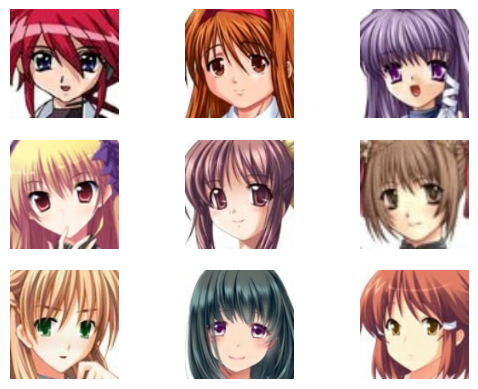

In [8]:
# Preview a batch of images
for images, _ in train_ds.take(1):  # Take one batch
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() * stats_std + stats_mean))  # Denormalize for display
        plt.axis("off")
    plt.show()


#2. Define the GAN Architecture

Generator: Creates new images that look like anime faces.

Discriminator: Distinguishes between real and fake anime face images.


##(a) Generator:

In [9]:
from tensorflow.keras import layers


def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(16 * 16 * 256, input_shape=(100,)),  # Latent space size = 100
        layers.Reshape((16, 16, 256)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # Add dropout
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # Add dropout
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # Add dropout
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')  # Ensure output is (128, 128, 3)
    ])
    return model

generator = build_generator()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Validate generator output shape
noise_dim = 100
noise = tf.random.normal([1, noise_dim])  # Generate a single random noise sample
generated_image = generator(noise, training=False)  # Generate image
print(f"Generated image shape: {generated_image.shape}")  # Should be (1, 128, 128, 3)


Generated image shape: (1, 128, 128, 3)


##(b) Discriminator

In [11]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(128, 128, 3)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),  # Add dropout
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),  # Add dropout
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),  # Add dropout
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')  # Probability of being real
    ])
    return model


#3. Define the GAN Training Process

**GAN Loss Functions:**

Discriminator Loss: Binary cross-entropy loss to distinguish between real and fake images.

Generator Loss: How well it fools the discriminator.

**Optimizer:**

Use Adam optimizers for both the generator and discriminator.

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


#4. Train the GAN

In [13]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16
noise_dim = 100

# Seed for consistent visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images, lables):

    images = tf.cast(images, tf.float32)  # Convert to float32
    noise = tf.random.normal([batch_size, noise_dim])  # Generator noise

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(noise, training=True)

        # Add noise to real and fake images
        real_images_with_noise = images + tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=0.1)
        generated_images_with_noise = generated_images + tf.random.normal(shape=tf.shape(generated_images), mean=0.0, stddev=0.1)

        # Discriminator outputs
        real_output = discriminator(real_images_with_noise, training=True)
        fake_output = discriminator(generated_images_with_noise, training=True)

        # Losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [14]:
for img, lbl in train_ds.take(1):
    print(img.dtype)  # should be <dtype: 'float32'>

<dtype: 'float32'>


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


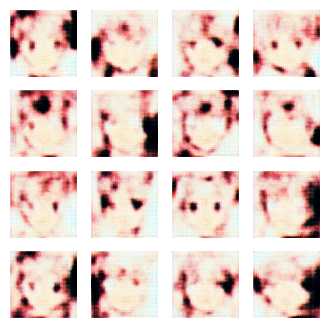

Epoch 1, Gen Loss: 8.395774841308594, Disc Loss: 0.03153971582651138
Epoch 2, Gen Loss: 6.758740425109863, Disc Loss: 0.08280187845230103
Epoch 3, Gen Loss: 7.1091718673706055, Disc Loss: 0.03634370118379593
Epoch 4, Gen Loss: 7.981329917907715, Disc Loss: 0.11065655201673508
Epoch 5, Gen Loss: 8.104369163513184, Disc Loss: 0.05510322377085686
Epoch 6, Gen Loss: 8.389378547668457, Disc Loss: 0.015165204182267189
Epoch 7, Gen Loss: 5.293331146240234, Disc Loss: 0.17245420813560486
Epoch 8, Gen Loss: 6.616330146789551, Disc Loss: 0.10315170884132385
Epoch 9, Gen Loss: 3.6468422412872314, Disc Loss: 0.5644761919975281
Epoch 10, Gen Loss: 5.443184852600098, Disc Loss: 0.45679086446762085


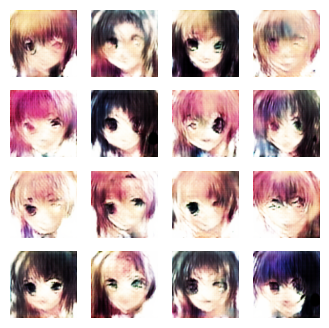

Epoch 11, Gen Loss: 6.724150657653809, Disc Loss: 0.031228747218847275
Epoch 12, Gen Loss: 6.446352958679199, Disc Loss: 0.2642585337162018
Epoch 13, Gen Loss: 5.735801696777344, Disc Loss: 0.13687410950660706
Epoch 14, Gen Loss: 6.656876564025879, Disc Loss: 0.37147149443626404
Epoch 15, Gen Loss: 6.944469451904297, Disc Loss: 0.17839916050434113
Epoch 16, Gen Loss: 3.208601713180542, Disc Loss: 0.49621668457984924
Epoch 17, Gen Loss: 5.87606954574585, Disc Loss: 0.17702093720436096
Epoch 18, Gen Loss: 5.840468406677246, Disc Loss: 0.17592935264110565
Epoch 19, Gen Loss: 3.201873779296875, Disc Loss: 0.3678193688392639
Epoch 20, Gen Loss: 5.989662170410156, Disc Loss: 0.22603408992290497


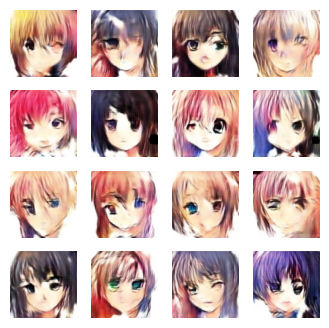

Epoch 21, Gen Loss: 5.7689361572265625, Disc Loss: 0.1329536736011505
Epoch 22, Gen Loss: 6.2255096435546875, Disc Loss: 0.1362464725971222
Epoch 23, Gen Loss: 5.341456413269043, Disc Loss: 0.24514345824718475
Epoch 24, Gen Loss: 4.905984878540039, Disc Loss: 0.12411149591207504
Epoch 25, Gen Loss: 5.888559818267822, Disc Loss: 0.12118168920278549
Epoch 26, Gen Loss: 6.056643486022949, Disc Loss: 0.18419384956359863
Epoch 27, Gen Loss: 7.384737491607666, Disc Loss: 0.07369042932987213
Epoch 28, Gen Loss: 6.63291072845459, Disc Loss: 0.06723346561193466
Epoch 29, Gen Loss: 7.0488715171813965, Disc Loss: 0.13884799182415009
Epoch 30, Gen Loss: 6.0891852378845215, Disc Loss: 0.14764481782913208


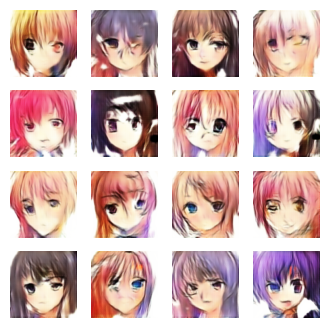

Epoch 31, Gen Loss: 6.046779632568359, Disc Loss: 0.1321992725133896
Epoch 32, Gen Loss: 6.065849304199219, Disc Loss: 0.060235053300857544
Epoch 33, Gen Loss: 6.120023727416992, Disc Loss: 0.07291977107524872
Epoch 34, Gen Loss: 6.310569763183594, Disc Loss: 0.13407090306282043
Epoch 35, Gen Loss: 6.2910661697387695, Disc Loss: 0.09342581033706665
Epoch 36, Gen Loss: 7.677006244659424, Disc Loss: 0.0358901247382164
Epoch 37, Gen Loss: 7.589653968811035, Disc Loss: 0.036774374544620514
Epoch 38, Gen Loss: 6.149234771728516, Disc Loss: 0.051835641264915466
Epoch 39, Gen Loss: 6.589547157287598, Disc Loss: 0.04163733124732971
Epoch 40, Gen Loss: 10.115184783935547, Disc Loss: 0.11937639862298965


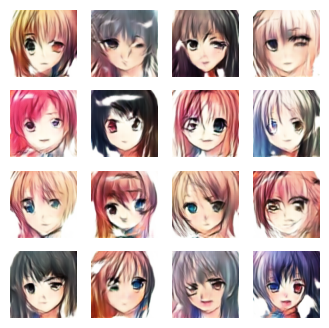

Epoch 41, Gen Loss: 7.287903308868408, Disc Loss: 0.03883546218276024
Epoch 42, Gen Loss: 7.603313446044922, Disc Loss: 0.036986093968153
Epoch 43, Gen Loss: 8.267474174499512, Disc Loss: 0.023054953664541245
Epoch 44, Gen Loss: 5.626189231872559, Disc Loss: 0.12220453470945358
Epoch 45, Gen Loss: 7.496635913848877, Disc Loss: 0.017091458663344383
Epoch 46, Gen Loss: 8.815032958984375, Disc Loss: 0.020914679393172264
Epoch 47, Gen Loss: 9.219074249267578, Disc Loss: 0.009486055001616478
Epoch 48, Gen Loss: 11.741771697998047, Disc Loss: 0.11404766887426376
Epoch 49, Gen Loss: 8.565820693969727, Disc Loss: 0.03830745443701744
Epoch 50, Gen Loss: 8.533379554748535, Disc Loss: 0.043246444314718246


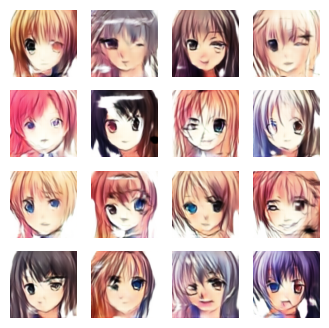

Epoch 51, Gen Loss: 8.922124862670898, Disc Loss: 0.019731922075152397
Epoch 52, Gen Loss: 7.833682060241699, Disc Loss: 0.03570485860109329
Epoch 53, Gen Loss: 10.754623413085938, Disc Loss: 0.04538532346487045
Epoch 54, Gen Loss: 11.096465110778809, Disc Loss: 0.04546331241726875
Epoch 55, Gen Loss: 7.0946364402771, Disc Loss: 0.05314726382493973
Epoch 56, Gen Loss: 14.246270179748535, Disc Loss: 0.06025572121143341
Epoch 57, Gen Loss: 8.704179763793945, Disc Loss: 0.020757528021931648
Epoch 58, Gen Loss: 9.824682235717773, Disc Loss: 0.05584648251533508
Epoch 59, Gen Loss: 10.303685188293457, Disc Loss: 0.03110377863049507
Epoch 60, Gen Loss: 10.855566024780273, Disc Loss: 0.03275640681385994


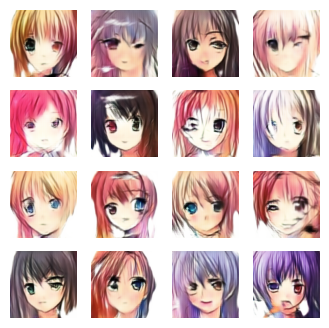

Epoch 61, Gen Loss: 13.354581832885742, Disc Loss: 0.04380737245082855
Epoch 62, Gen Loss: 7.998056888580322, Disc Loss: 0.028513412922620773
Epoch 63, Gen Loss: 9.782712936401367, Disc Loss: 0.024912308901548386
Epoch 64, Gen Loss: 10.75429916381836, Disc Loss: 0.04176131635904312
Epoch 65, Gen Loss: 10.546646118164062, Disc Loss: 0.007224935572594404
Epoch 66, Gen Loss: 13.9426908493042, Disc Loss: 0.11746081709861755
Early stopping triggered at epoch 66


In [15]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.01):
        self.patience = patience  # Number of epochs to wait before stopping
        self.min_delta = min_delta  # Minimum improvement to be considered significant
        self.best_loss = float('inf')  # Best loss seen so far
        self.wait = 0  # Epochs since last improvement

    def __call__(self, current_loss):
        if self.best_loss - current_loss > self.min_delta:
            self.best_loss = current_loss
            self.wait = 0  # Reset wait counter
        else:
            self.wait += 1

        # Stop training if patience is exceeded
        return self.wait >= self.patience


def train(dataset, epochs):
    early_stopping = EarlyStopping(patience=50, min_delta=0.01)
    for epoch in range(epochs):
        for image_batch, label_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, label_batch)

        # Produce and save images every 10 epochs
        if epoch % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)
        print(f"Epoch {epoch + 1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}")

        # Check early stopping condition
        if early_stopping(gen_loss):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break


def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] * 0.5 + 0.5))  # Denormalize to [0, 1]
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

# Initialize models
generator = build_generator()
discriminator = build_discriminator()

# Start training
train(train_ds, EPOCHS)

In [16]:
noise = tf.random.normal([1, noise_dim])  # Single noise sample
generated_image = generator(noise, training=False)
print(f"Generated image shape: {generated_image.shape}")

Generated image shape: (1, 128, 128, 3)


#5. Evaluate and Generate Images

In [21]:
def generate_anime_faces(generator, num_images=5):
    noise = tf.random.normal([num_images, noise_dim])  # Generate random noise
    generated_images = generator(noise, training=False)  # Generate images

    # Ensure correct denormalization
    for i in range(num_images):
        plt.imshow((generated_images[i].numpy() * 0.5 + 0.5).clip(0, 1))  # Clip values
        plt.axis("off")
        plt.show()


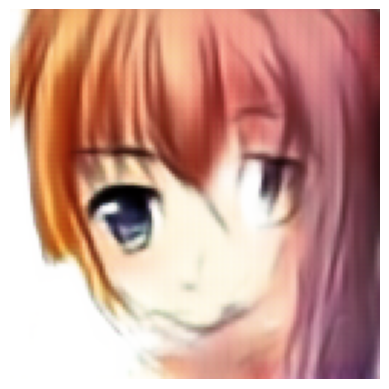

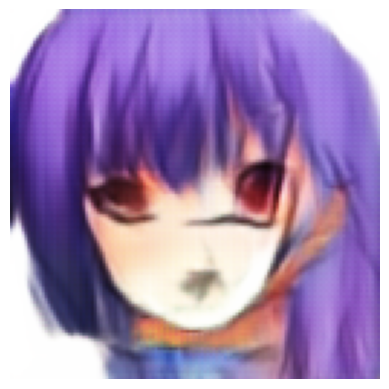

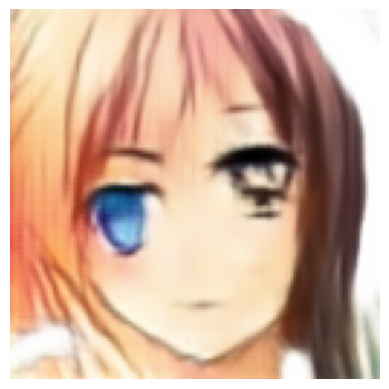

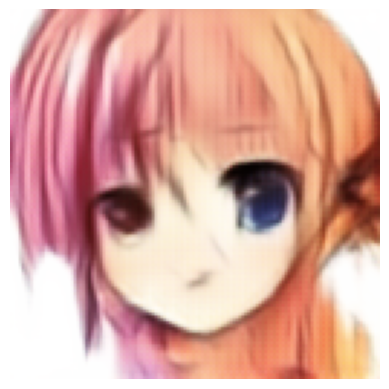

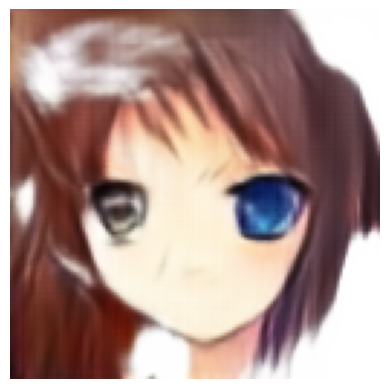

In [22]:
generate_anime_faces(generator)